<a href="https://colab.research.google.com/github/Lasulux/Midterm_Project/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preview code from:
https://www.kaggle.com/kmader/malaria-preview

Visualization code from:
https://github.com/maki-ai/SSD-Tensorflow/blob/pazmany_dl/notebooks/visualization.py

sliding window tutorial at: https://www.pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/ and https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/


Attaching my drive to load data:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The big importing: \\[T]/ 

In [2]:
%matplotlib inline
import pickle
import math
import tensorflow as tf 
import time
import imutils
import cv2
import os
import random
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import matplotlib.cm as mpcm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path
from skimage.io import imread
from skimage.color import label2rgb
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop, Adam
from keras import regularizers
from tensorflow import keras
import sklearn
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
malaria_dir = Path('../input/malaria/malaria/')

Using TensorFlow backend.


This visualization code draws the bboxes and attaches the category number and score:

In [0]:
def plt_bboxes(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!"""
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            plt.gca().text(xmin, ymin - 2,
                           '{:s} | {:.3f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=5, color='white')
    plt.show()

This is just a small block to switch the category names to numbers because if you display the whole names the image becomes too crowded to see anything...:

In [0]:
def cat_to_num(category):
  categories = ['red blood cell','leukocyte','trophozoite','ring','schizont','gametocyte','difficult','background']
  num = categories.index(category)
  return num

Read data json, get path, show me some. Just to see what I have in the dataframe:

In [7]:
train_df = pd.read_json('/content/drive/My Drive/malaria-bounding-boxes/malaria/malaria/training.json')
train_df['path'] = train_df['image'].map(lambda x:  x['pathname'][1:])
print(train_df.shape[0], 'images')
train_df.sample(5)

1208 images


,image,objects,path
776,{'checksum': '6a6dc52d26b4730df02b9dc0b4f23485...,"[{'bounding_box': {'minimum': {'r': 702, 'c': ...",images/f01f6659-2114-4801-9d28-1f411432a589.png
857,{'checksum': '7438454392b00c9f119bb0c014159517...,"[{'bounding_box': {'minimum': {'r': 404, 'c': ...",images/afd39466-aafa-4d81-9520-483727418723.png
931,{'checksum': '5518d366d6f72688b885be56245c7aa9...,"[{'bounding_box': {'minimum': {'r': 975, 'c': ...",images/f5c395f1-f94c-440d-8221-cc656e52c0b1.png
783,{'checksum': 'cab68b40156e2d4172e1cf21136b2551...,"[{'bounding_box': {'minimum': {'r': 90, 'c': 1...",images/db0a1123-0b35-48d7-8337-3b1ebd6af0cc.png
91,{'checksum': 'bc5f865db1e400ec739356c2f2a219fb...,"[{'bounding_box': {'minimum': {'r': 383, 'c': ...",images/d3dcdf92-9328-4796-adf4-918646877ba1.png


In [21]:
test_df = pd.read_json('/content/drive/My Drive/malaria-bounding-boxes/malaria/malaria/test.json')
test_df['path'] = test_df['image'].map(lambda x:  x['pathname'][1:])
print(test_df.shape[0], 'images')
test_df.sample(5)

120 images


,image,objects,path
45,{'checksum': '042a4c0a479ede0a29c50ca81e7fd2f0...,"[{'bounding_box': {'minimum': {'r': 850, 'c': ...",images/446734b7-6bc9-4a66-a3a0-49f6aa90db33.jpg
115,{'checksum': '57d00c945b5e0b7995c75b9b4c57b579...,"[{'bounding_box': {'minimum': {'r': 483, 'c': ...",images/e26b88c6-5884-4b5c-94d7-ad780379c8ad.jpg
107,{'checksum': '136dfc01c20111d01825314096f72763...,"[{'bounding_box': {'minimum': {'r': 840, 'c': ...",images/0a3b53c7-e7ab-4135-80aa-fd2079d727d6.jpg
13,{'checksum': '6b0890e55925fa17557a1b8802031c20...,"[{'bounding_box': {'minimum': {'r': 129, 'c': ...",images/738b7be5-59b5-4d8c-8769-cbf2385b9fc7.jpg
27,{'checksum': 'e78e365fce74d66c91b1bc1c0d29c3b5...,"[{'bounding_box': {'minimum': {'r': 656, 'c': ...",images/3e03b313-66eb-471f-a97a-7b2bf20dcff5.jpg


Choose an image, find all objects in it and put them in arrays then draw the bboxes from the them. Also draw the image:

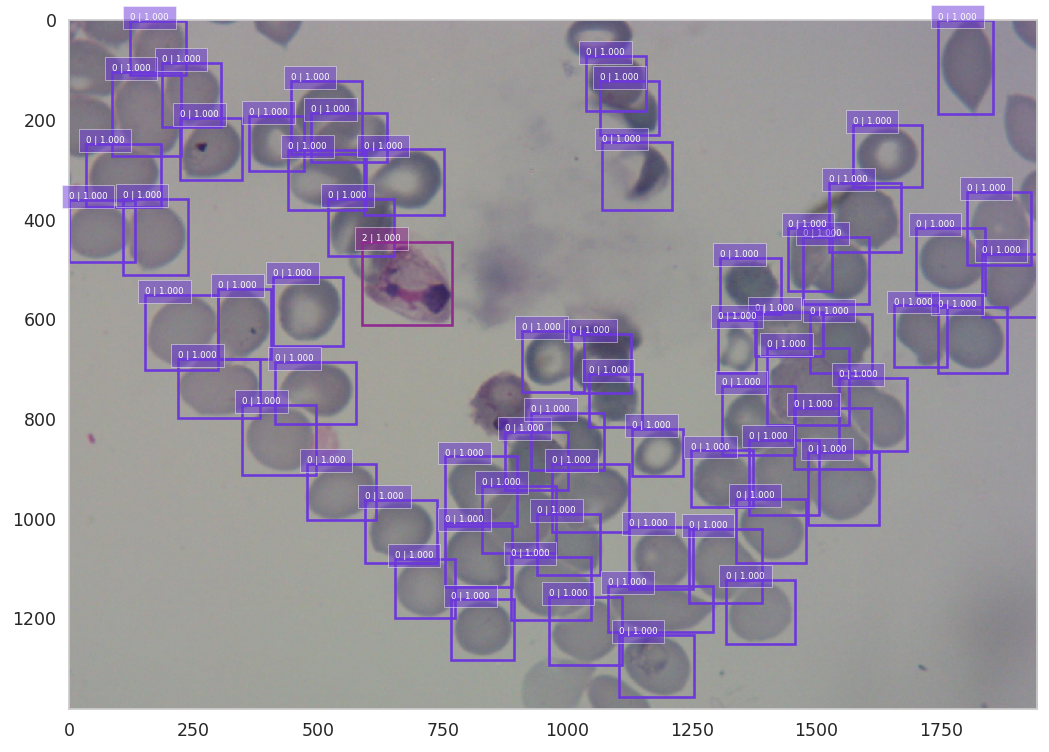

In [7]:
test_row = test_df.iloc[0]
def show_image_boxes(in_row, ax=None):
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + in_row['path'])
    lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
    classes=[]
    scores=[]
    bboxes=[]
    for c_obj in in_row['objects']:
        bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
        bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
        bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
        bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]
        classes.append(cat_to_num(c_obj['category']))
        scores.append(1.00)
        bboxes.append([bbx1,bby1,bbx2,bby2])
    bboxes=np.array(bboxes)
    classes=np.array(classes)
    scores=np.array(scores)
    bboxes=np.reshape(bboxes,(-1,4))
    plt_bboxes(c_img, classes, scores, bboxes)
show_image_boxes(test_row)

Checking a few dozen pictures, the cells are about the same size on every picture. I will try applying a sliding window with about this size to find unhealthy cells. Since we want to know whether the blood is healthy or infected, not knowing the exact number of infected cells on picture SHOULD be fine, but I'll try to overcome that when (IF) I get there.

Slidey window:

In [0]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image ٩(^ᴗ^)۶
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

Just a small image getter to use later:

In [0]:
def get_image(number,istest=False):
  if (istest==True):
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + test_df.iloc[number]['path'])
    return c_img
  else:
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + train_df.iloc[number]['path'])
    return c_img
#plt.imshow(get_image(5))

Image resizing snippet:

In [0]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
  # yield the original image
    yield image

  # keep looping over the pyramid
  #while True: #indent here!
  # compute the new dimensions of the image and resize it
    w = int(image.shape[1] / scale)
    image = imutils.resize(image, width=w)

  # if the resized image does not meet the supplied minimum
  # size, then stop constructing the pyramid
    #if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
     # break

  # yield the next image in the pyramid
   # yield image


IOU calculation for the overlapping bboxes.

In [0]:
def calc_iou(bbox1,bbox2):

    def intersection (bbox1,bbox2):
      return max(bbox1[2] - bbox2[0],0)*max(bbox1[3] - bbox2[1],0)

    def union (bbox1,bbox2):
      return (bbox1[2]-bbox1[0]) * (bbox1[3]-bbox1[1]) + (bbox2[2]-bbox2[0]) * (bbox2[3]-bbox2[1]) - intersection (bbox1,bbox2)

    IoU = intersection(bbox1,bbox2)/union(bbox1,bbox2)
    return IoU

Function for discarding overlapping boxes.

In [0]:
def bboxes_nms(classes,scores,bboxes,nms_threshold=0.45):
    newclasses=[]
    newscores=[]
    newbboxes=[]
    available=np.full((classes.shape[0]), True, dtype=bool)
    for i, val in enumerate(classes):
      for j, val in enumerate(classes):
        if(classes[i]==classes[j] and j!=i):
          if (calc_iou(bboxes[i],bboxes[j])>=nms_threshold):
            if (scores[i]>=scores[j]):
              available[j]=False
              if available[i]:
                available[i]=False
                newbboxes.append(bboxes[i][0])
                newbboxes.append(bboxes[i][1])
                newbboxes.append(bboxes[i][2])
                newbboxes.append(bboxes[i][3])
                newclasses.append(classes[i])
                newscores.append(scores[i])
            else:
              available[i]=False
              if available[j]:
                available[j]=False
                newclasses.append(classes[j])
                newscores.append(scores[j])
                newbboxes.append(bboxes[j][0])
                newbboxes.append(bboxes[j][1])
                newbboxes.append(bboxes[j][2])
                newbboxes.append(bboxes[j][3])
    newbboxes=np.array(newbboxes)
    newclasses=np.array(newclasses)
    newscores=np.array(newscores)
    newbboxes=np.reshape(newbboxes,(-1,4))
    return newclasses,newscores,newbboxes

Take an image, slide the window all over it, scale down image and do it again. Should be able to find any bigger cells with just one resize. I'll use this to generate training data from individual cell images.

In [0]:
Winsize= 128
stepsize= math.ceil(Winsize * 0.4)
(winW, winH) = (Winsize, Winsize)
figsize=(10,10)
fig = plt.figure(figsize=figsize)
image = get_image(5)
height = image.shape[0]
width = image.shape[1]
colors = dict()
iou_threshold=0.8
img_num=5

# loop over the image pyramid
for resized in pyramid(image, scale=1.5):
  #get an original image this will be in loop later too
  c_img=get_image(img_num)
  lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
  classes=[]
  bboxes=[] #no need for scores, this is training data
  for c_obj in train_df.iloc[img_num]['objects']:#get original bboxes from image with classes
      bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
      bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
      bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
      bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]
      bboxes.append([bbx1,bby1,bbx2,bby2])
      classes.append(cat_to_num(c_obj['category']))
  bboxes=np.array(bboxes)
  classes=np.array(classes)
	
  #the bboxes our window should find
  winbboxes=[]
  winscores=[]
  winclasses=[]

  #slidey windOwO
  for (x, y, window) in sliding_window(resized, stepsize, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it. This seems useless but i'll keep it for now.
    if window.shape[0] != winH or window.shape[1] != winW:
      continue
    #get window coords, declare a winning bbox
    wincoord=np.array([y/lab_img.shape[0], x/lab_img.shape[1], (y+winH)/lab_img.shape[0], (x+winW)/lab_img.shape[1]])
    winbbox=np.array([0.0,0.01,0.0,0.01])
    winscore=0
    winclass=0
    for j,val in enumerate(bboxes): #find the most matching gt bbox to our window thats above threshold and save it
      if (calc_iou(wincoord,bboxes[j])>=calc_iou(wincoord,winbbox)):
        if calc_iou(wincoord,bboxes[j])>=iou_threshold: 
          winbbox=wincoord
          winscore=calc_iou(wincoord,bboxes[j])
          winclass=classes[j]

    if winscore!=0: #if you found a matching bbox above threshold add it to the winner window list
      winbboxes.append(winbbox)
      winscores.append(winscore)
      winclasses.append(winclass)

  winbboxes=np.array(winbboxes)
  winscores=np.array(winscores)
  winclasses=np.array(winclasses)
  winbboxes=np.reshape(winbboxes,(-1,4))

  #winclasses, winscores, winbboxes = bboxes_sort(winclasses, winscores, winbboxes, top_k=400)
  winclasses,winscores,winbboxes=bboxes_nms(winclasses,winscores,winbboxes,nms_threshold=0.01)
  winclasses,winscores,winbboxes=bboxes_nms(winclasses,winscores,winbboxes,nms_threshold=0.01)
  winclasses,winscores,winbboxes=bboxes_nms(winclasses,winscores,winbboxes,nms_threshold=0.01)
  winclasses,winscores,winbboxes=bboxes_nms(winclasses,winscores,winbboxes,nms_threshold=0.01)
  print(bboxes.shape[0],"---mine:", winbboxes.shape[0])
  plt_bboxes(c_img, winclasses, winscores, winbboxes)
        #print("found match at: x:",x," - y:",y,"   iou:",calc_iou(wincoord,bboxes[j]) )
        #print(" wincoord:",wincoord," - bbox:",bboxes[j],"   iou:",calc_iou(wincoord,bboxes[j]) )
    # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
    # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
    # WINDOW

    # since we do not have a classifier, we'll just draw the window
    #clone = resized.copy()
    #cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
    #plt.imshow(clone)
    #plt.show()
    #cv2.waitKey(1) #0 buttonpress trigger, 1 1 ms trigger (supposedly)
    #time.sleep(4)
    #clear_output()



Cut out the individual cells and label them

In [0]:
def gen_train_cells(dataframe=train_df,tfrom=0,tto=1,tfilter=True,vvfilter=0.05,t2filter=0.5,rotate=False,rotval=1):
  from skimage.transform import resize
  from google.colab import files
  lower_text_classes=[]
  lower_classes=[]
  lower_bboxes=[]
  lower_bboximages=[]
  lower_text_classes.clear()
  lower_classes.clear()
  lower_bboxes.clear()
  lower_bboximages.clear()
  j=0
  end=dataframe.shape[0]
  vvcount=0
  t2count=0
  for j in range(math.ceil(end*tfrom),math.ceil(end*tto)):#math.ceil(end/4)
    c_img=get_image(j)
    lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
    #print("   i=",i)
    i=0
    
    if (j%10==0):
      print(j)
    for c_obj in dataframe.iloc[j]['objects']:#get original bboxes from image with classes
        bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
        bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
        bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
        bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]
        if tfilter==True:
          if (cat_to_num(c_obj['category']))==0 :
            vvcount=vvcount+1
            if(vvcount%(1/vvfilter)==0):
              lower_bboxes.append([bbx1,bby1,bbx2,bby2])
              lower_classes.append(cat_to_num(c_obj['category']))
              lower_text_classes.append(c_obj['category'])
              img2 = c_img[math.ceil(c_img.shape[0]*bbx1):math.ceil(c_img.shape[0]*bbx2),math.ceil( c_img.shape[1]*bby1):math.ceil(c_img.shape[1]*bby2),:]
              img2 = resize(img2, (128, 128))
              if rotate==True:
                if rotval==1:
                  lower_bboximages.append(img2.swapaxes(-3,-2))
                elif rotval==2:
                  lower_bboximages.append(img2.swapaxes(-3,-2)[::-1,:,:])
                elif rotval==3:
                  lower_bboximages.append(img2.swapaxes(-3,-2)[:,::-1,:])
              else:
                lower_bboximages.append(img2)
          elif (cat_to_num(c_obj['category']))==2 :
            t2count=t2count+1
            if(t2count%(1/t2filter)==0):
              lower_bboxes.append([bbx1,bby1,bbx2,bby2])
              lower_classes.append(cat_to_num(c_obj['category']))
              lower_text_classes.append(c_obj['category'])
              img2 = c_img[math.ceil(c_img.shape[0]*bbx1):math.ceil(c_img.shape[0]*bbx2),math.ceil( c_img.shape[1]*bby1):math.ceil(c_img.shape[1]*bby2),:]
              img2 = resize(img2, (128, 128))
              if rotate==True:
                if rotval==1:
                  lower_bboximages.append(img2.swapaxes(-3,-2))
                elif rotval==2:
                  lower_bboximages.append(img2.swapaxes(-3,-2)[::-1,:,:])
                elif rotval==3:
                  lower_bboximages.append(img2.swapaxes(-3,-2)[:,::-1,:])
              else:
                lower_bboximages.append(img2)
          else:
            lower_bboxes.append([bbx1,bby1,bbx2,bby2])
            lower_classes.append(cat_to_num(c_obj['category']))
            lower_text_classes.append(c_obj['category'])
            img2 = c_img[math.ceil(c_img.shape[0]*bbx1):math.ceil(c_img.shape[0]*bbx2),math.ceil( c_img.shape[1]*bby1):math.ceil(c_img.shape[1]*bby2),:]
            img2 = resize(img2, (128, 128))
            if rotate==True:
              if rotval==1:
                lower_bboximages.append(img2.swapaxes(-3,-2))
              elif rotval==2:
                lower_bboximages.append(img2.swapaxes(-3,-2)[::-1,:,:])
              elif rotval==3:
                lower_bboximages.append(img2.swapaxes(-3,-2)[:,::-1,:])
            else:
              lower_bboximages.append(img2)
        else:
          lower_bboxes.append([bbx1,bby1,bbx2,bby2])
          lower_classes.append(cat_to_num(c_obj['category']))
          lower_text_classes.append(c_obj['category'])
          img2 = c_img[math.ceil(c_img.shape[0]*bbx1):math.ceil(c_img.shape[0]*bbx2),math.ceil( c_img.shape[1]*bby1):math.ceil(c_img.shape[1]*bby2),:]
          img2 = resize(img2, (128, 128))
          if rotate==True:
            if rotval==1:
              lower_bboximages.append(img2.swapaxes(-3,-2))
            elif rotval==2:
              lower_bboximages.append(img2.swapaxes(-3,-2)[::-1,:,:])
            elif rotval==3:
              lower_bboximages.append(img2.swapaxes(-3,-2)[:,::-1,:])
          else:
            lower_bboximages.append(img2)
        #if (i%100==0):
        
        i=i+1
  return lower_bboximages,lower_classes,lower_bboxes

In [19]:
#gen_train_cells(dataframe=train_df,tfrom=0,tto=1,tfilter=False,vvfilter=0.01,t2filter=0.2,rotate=False) ___:test_df
#lower_bboximages,lower_classes,lower_bboxes= gen_train_cells(tto=0.5)
#upper_bboximages,upper_classes,upper_bboxes= gen_train_cells(tfrom=0.5,tto=1)
#lower_rot_bboximages,lower_rot_classes,lower_rot_bboxes= gen_train_cells(tto=0.5,rotate=True)
upper_rot_bboximages,upper_rot_classes,upper_rot_bboxes= gen_train_cells(tfrom=0.5,tto=1,rotate=True)

#lower_rot2_bboximages,lower_rot2_classes,lower_rot2_bboxes= gen_train_cells(tto=0.5,rotate=True,rotval=2)
#upper_rot2_bboximages,upper_rot2_classes,upper_rot2_bboxes= gen_train_cells(tfrom=0.5,tto=1,rotate=True,rotval=2)

#lower_rot3_bboximages,lower_rot3_classes,lower_rot3_bboxes= gen_train_cells(tto=0.5,rotate=True,rotval=3)
#upper_rot3_bboximages,upper_rot3_classes,upper_rot3_bboxes= gen_train_cells(tfrom=0.5,tto=1,rotate=True,rotval=3)

610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


In [22]:
from skimage.transform import resize
from google.colab import files
ttext_classes=[]
tclasses=[]
tbboxes=[]
tbboximages=[]
ttext_classes.clear()
tclasses.clear()
tbboxes.clear()
tbboximages.clear()
j=0
end=test_df.shape[0]
for j in range(0,end):
  tc_img=get_image(j,istest=True)
  tlab_img = np.zeros((tc_img.shape[0], tc_img.shape[1]), dtype='int')
  #print("   i=",i)
  i=0
  if (j%10==0):
    print(j)
  for tc_obj in test_df.iloc[j]['objects']:#get original bboxes from image with classes
      bbx1 = tc_obj['bounding_box']['minimum']['r']/tlab_img.shape[0]
      bby1 = tc_obj['bounding_box']['minimum']['c']/tlab_img.shape[1]
      bbx2 = tc_obj['bounding_box']['maximum']['r']/tlab_img.shape[0]
      bby2 = tc_obj['bounding_box']['maximum']['c']/tlab_img.shape[1]
      tbboxes.append([bbx1,bby1,bbx2,bby2])
      tclasses.append(cat_to_num(tc_obj['category']))
      ttext_classes.append(tc_obj['category'])
      img2 = tc_img[math.ceil(tc_img.shape[0]*bbx1):math.ceil(tc_img.shape[0]*bbx2),math.ceil( tc_img.shape[1]*bby1):math.ceil(tc_img.shape[1]*bby2),:]
      img2 = resize(img2, (128, 128))
      tbboximages.append(img2)
      #if (i%100==0):
      
      i=i+1
#data=pd.DataFrame([bboximages,classes,bboxes])
#data.to_json('test.json')
#data = pd.read_json('test.json')

0
10
20
30
40
50
60
70
80
90
100
110


In [0]:
tbboximages=np.array(tbboximages)
tbboxes=np.array(tbboxes)
tclasses=np.array(tclasses)
tbboxes=np.reshape(tbboxes,(-1,4))

In [0]:
upper_rot_bboxes=np.array(upper_rot_bboxes)

In [0]:
upper_rot_classes=np.array(upper_rot_classes)

In [0]:
upper_rot_bboximages=np.array(upper_rot_bboximages)

In [0]:
lower_rot_bboxes=np.array(lower_rot_bboxes)

In [0]:
lower_rot_classes=np.array(lower_rot_classes)

In [0]:
lower_rot_bboximages=np.array(lower_rot_bboximages)

In [0]:
train_bboximages=np.concatenate((lower_bboximages,upper_bboximages),axis=0)
train_bboximages=np.concatenate((train_bboximages,upper_rot_bboximages),axis=0)
train_bboximages=np.concatenate((train_bboximages,lower_rot_bboximages),axis=0)

train_classes=np.concatenate((lower_classes,upper_classes),axis=0)
train_classes=np.concatenate((train_classes,upper_rot_classes),axis=0)
train_classes=np.concatenate((train_classes,lower_rot_classes),axis=0)

In [0]:
train_bboximages=np.concatenate((train_bboximages,upper_rot2_bboximages),axis=0)
train_bboximages=np.concatenate((train_bboximages,lower_rot2_bboximages),axis=0)

In [0]:
train_bboximages=np.concatenate((train_bboximages,upper_rot3_bboximages),axis=0)
train_bboximages=np.concatenate((train_bboximages,lower_rot3_bboximages),axis=0)

In [0]:
train_classes=np.concatenate((train_classes,upper_rot2_classes),axis=0)
train_classes=np.concatenate((train_classes,lower_rot2_classes),axis=0)

In [0]:
train_classes=np.concatenate((train_classes,upper_rot3_classes),axis=0)
train_classes=np.concatenate((train_classes,lower_rot3_classes),axis=0)

In [60]:
unique, counts = np.unique(train_classes, return_counts=True)
print(dict(zip(unique, counts)))

{0: 773, 1: 103, 2: 294, 3: 353, 4: 179, 5: 144, 6: 441}


View some individual cells and their labels

In [0]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows+1 ):
    ax=fig.add_subplot(rows, columns, i)
    r1 = random.randint(1, 3384) 
    ax.set_title(tclasses[i+100])
    
    plt.imshow(tbboximages[i+100])
    
    plt.axis('off')
plt.tight_layout()
plt.show()

In [0]:
plt.figure(figsize=(8, 8))
plt.title(tclasses[63])
plt.imshow(tbboximages[63].swapaxes(-2,-3)[::-1,:,:]) #[...,::-1]
plt.show()

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (128,128,3)))#X.shape[1:]),)
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) 
model.add(tf.keras.layers.Dropout(0.3)) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='softmax'))


model.compile(loss="sparse_categorical_crossentropy",
				optimizer='ADAM',#RMSprop(lr=0.001)
				metrics=["accuracy"])

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [45]:
history = model.fit(train_bboximages, train_classes, batch_size=32, epochs=10, verbose=1,validation_data=(tbboximages, tclasses))#validation_data=(tbboximages, tclasses)

Train on 11652 samples, validate on 5922 samples
Epoch 1/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.4077 - acc: 0.8504 - val_loss: 0.1879 - val_acc: 0.9590
Epoch 2/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.3746 - acc: 0.8610 - val_loss: 0.1602 - val_acc: 0.9603
Epoch 3/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.3717 - acc: 0.8640 - val_loss: 0.1841 - val_acc: 0.9586
Epoch 4/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.3125 - acc: 0.8837 - val_loss: 0.2449 - val_acc: 0.9593
Epoch 5/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.2738 - acc: 0.8989 - val_loss: 0.3173 - val_acc: 0.9509
Epoch 6/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.2710 - acc: 0.9000 - val_loss: 0.1967 - val_acc: 0.9598
Epoch 7/10
11652/11652 [==============================] - 30s 3ms/sample - loss: 0.2448 - acc: 0.9106 - val_loss: 0.2

In [101]:
image_number=122 #63, 120,121,122
testimage=np.expand_dims(tbboximages[image_number],axis=0)
model.predict(testimage)

array([[2.8214442e-02, 2.6283858e-03, 5.4995143e-01, 2.3847211e-02,
        2.1447979e-02, 4.2129930e-02, 3.3173451e-01, 4.6081364e-05]],
      dtype=float32)

In [92]:
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

Saved model to disk


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


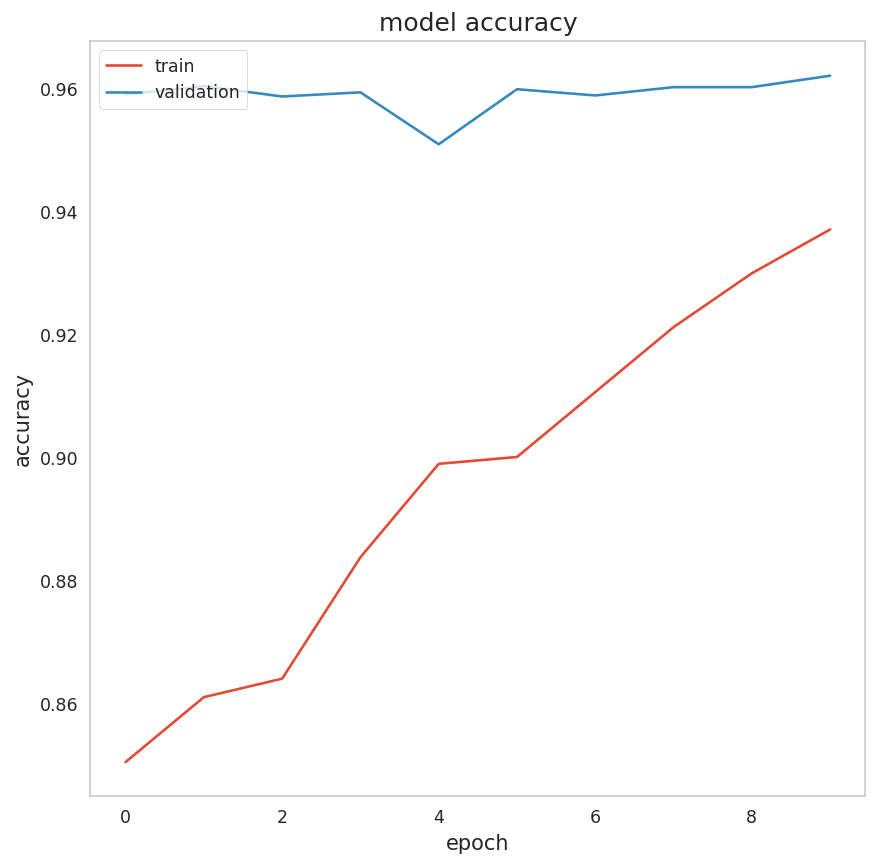

In [80]:
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

[0.028214442, 0.0026283858, 0.54995143, 0.023847211, 0.021447979, 0.04212993, 0.3317345, 4.6081364e-05]


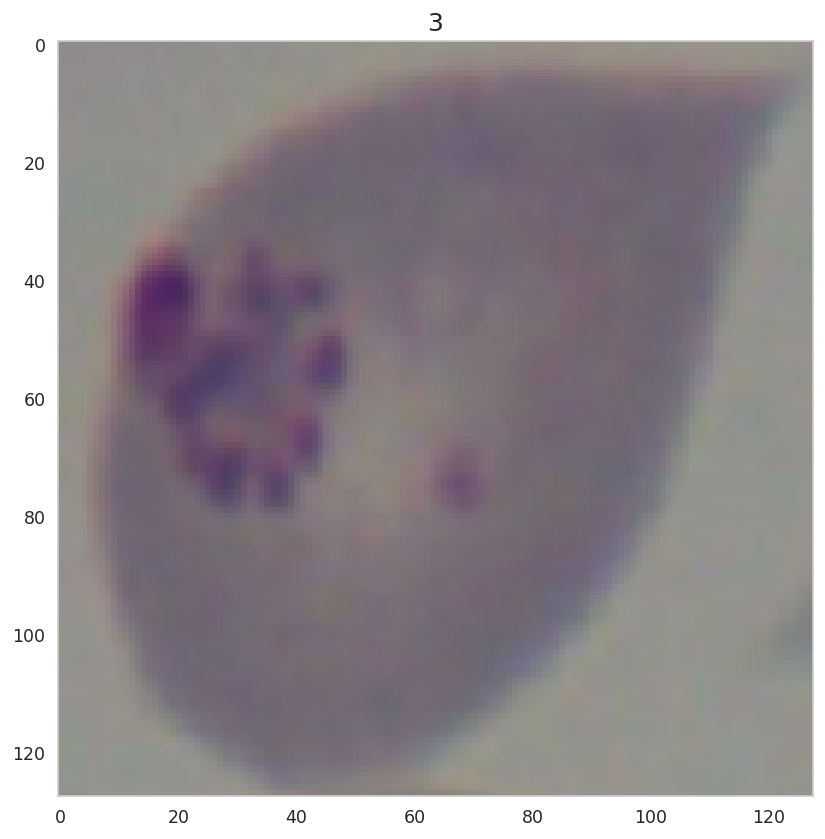

In [102]:
image_number=122 #63, 120,121,122
#testmodel = tf.keras.models.load_model("CNN.model")
testimage=np.expand_dims(tbboximages[image_number],axis=0) #class 2 
#testimage = np.expand_dims(resize(imread('/content/Capture.JPG'), (128, 128)),axis=0)
prediction = model.predict(testimage)
prediction = list(prediction[0])
#print(prediction.index(max([prediction])))
print(prediction)
plt.figure(figsize=(8, 8))
plt.title(tclasses[image_number])
#plt.imshow(resize(imread('/content/Capture.JPG'), (128, 128)))
plt.imshow(tbboximages[image_number])
plt.show()